# RNN training tutorial

This is a tutorial training various RNNs on simple datasets and doing some analysis.

Structure:

  1. basic (vanilla RNN) implementation
  2. observing exploding/vanishing gradients
  3. training an LSTM on character level langugage modelling task
    * comparing training of an LSTM and RNN, playing with architectures
  4. Intepretability by plotting and analysing activations of a network:
    * identifying interpretable neurons
    * identifying neurons-gates interactions
    * identifying hidden state dynamics through time
  
    

First three sections are almost independent, one can go switch between them without any code dependencies (apart from being unable to use vanilla RNN in section 4, if it was not implemented in 1.).

Cells that include "starting point" in their title require filling in some code gaps; all remaining ones are complete (but feel free to play with them if you want!)

Please pay attention to questions after each section. Finding out answers to these is crucial to make sure one understands various modes of RNN operation.

Language model exercises are based on [Sonnet LSTM example](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/rnn_shakespeare.py).
Apart from loading the dataset, we make no further use of Sonnet in this colab.

## Imports

We will use tf.nn.rnn_cell and tf.layers.

In [0]:
#@title Imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow.nn.rnn_cell as rnn_cell
tf.logging.set_verbosity(tf.logging.ERROR)

from matplotlib import pyplot as plt

from sonnet.examples import dataset_shakespeare
  
sns.set_style('ticks')  


# Ex 1.    Vanilla RNN

Implement basic RNN cell using tf.layers.

   $$ h_t = f( Wx_t + Vh_{t-1}  + b) $$
   
   Where
   
   * $x_t$ input at time $t$
   * $h_t$ hidden state at time $t$
   * $W$ input-to-hidden mapping (trainable)
   * $V$ hidden-to-hidden mapping (trainable)
   * $b$ bias (trainable)
   * $f$ non-linearity chosen (usually tanh)
   
   
   You do not need to worry about the plotting and running code, but focus on the RNN implementation.

In [0]:
#Hint: 'tf.layers.Dense' implements simple linear layers

tf.layers.Dense?

In [0]:
#@title Vanilla RNN - Solution
class RNN(rnn_cell.RNNCell):
  
  def __init__(self, hidden_size, activation=tf.tanh, name="vanilla_rnn"):    
    """
    Args:
    
      hidden_size: number of hidden units
      activation: function constructing activation op
      name: name of the core
    """    
    # We have to call parent's constructor with the name provided
    super(RNN, self).__init__(name=name)

    # Save these arguments for later
    self._hidden_size = hidden_size  # Must be an integer
    self._activation = activation  # Notice this function will construct an op.


  def build(self, input_shape):
    """
    This function will is typically used to create the variables of the model.
    
    Args:
  
      input_shape: tensor shape of the input
    """
    
    ######################
    #   YOUR CODE HERE   #
    ######################
    # Use a linear layer to implement the trainable input to hidden
    # mapping "W" and the trainable bias "b", see hint above
    # Please note that such a layer *will* also implement the bias by default
    # Please don't connect it to anything yet
    self._in_to_hidden_linear = None


    ######################
    #   YOUR CODE HERE   #
    ######################
    # Use another linear layer to implement the trainable
    # hidden to hidden mapping "V"
    # Please note that this second layer does not require a bias,
    # since the first layer already implements it
    # Please don't connect it to anything yet
    self._hidden_to_hidden_linear = None

    #### SOLUTION: 
    self._in_to_hidden_linear = tf.layers.Dense(
        self._hidden_size, name="in_to_hidden")

    self._hidden_to_hidden_linear = tf.layers.Dense(
        self._hidden_size, use_bias=False, name="hidden_to_hidden")
    
    msg = ("Implement a linear 'Dense' mapping from input to hidden "
           "with 'self._hidden_size' units")
    assert self._in_to_hidden_linear is not None, msg

    msg = "Implement a linear 'Dense' layer "
    assert self._hidden_to_hidden_linear is not None, msg


  def call(self, input_, prev_state):
    """
    This function will be called in a loop, when RNN core is connected to
    ops creating inputs and previous states.
    
    Args:
    
      input_: tensor containing current x_t
      prev_state: tensor containing previous state, h_{t-1}
    """

    ######################
    #   YOUR CODE HERE   #
    ######################
    # Compute the output of the RNN Cell by implementing the equation above.
    output = None


    # Solution
    in_to_hidden = self._in_to_hidden_linear(input_)
    hidden_to_hidden = self._hidden_to_hidden_linear(prev_state)
    output = self._activation(in_to_hidden + hidden_to_hidden)

    assert output is not None, "The RNN must compute the output"

    # Cores return pairs of (o_t, h_t) where o_t is the output exposed
    # to the rest of the code, for vanilla RNN these are the same quantities
    return output, output


  @property
  def state_size(self):
    return tf.TensorShape([self._hidden_size])


  @property
  def output_size(self):
    return tf.TensorShape([self._hidden_size])

### Train the RNN

Train the RNN on sine data - predict the next sine value from *predicted* sine values.

Predict   $$ sin (x +t \epsilon) $$ from $$ sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) $$

In particular, we want the network to predict the next value in a loop, conditioning the prediction on some initial values (provided) and all subsequent predictions.

To learn the prediction model, we will use *teacher forcing*. This means that when training the model, the input at time $t$ is the real sequence at time $t$, rather than the output produced by the model at $t-1$. When we want to generate data from the model, we do not have access to the true sequence, so we do not use teacher forcing. However, in the case of our problem, we will also use *warm starting*, because we require multiple time steps to predict the next sine wave value (at least 2, for the initial value and for the step). 

The code below unrolls the RNN core you have defined above, does the training using backprop though time and plots the real data ("ground truth"), the data generated during training ("train predictions") and the model samples "generated".


In [0]:
# Hint:
help(rnn_cell.RNNCell.get_initial_state)

In [0]:
#@title Training a simple sequence, using teacher forcing and sampling

UNROLL_LENGTH = 30  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING = False  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.0001  #@param {type:"number"}
REPORTING_INTERVAL = 2000  #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

tf.reset_default_graph()

######################
#   YOUR CODE HERE   #
######################
# Create an RNN object using the class we defined in the previous cell
rnn = None

# Solution
rnn = RNN(HIDDEN_UNITS)


assert rnn is not None, "Create an RNN object using the class defined above."

######################
#   YOUR CODE HERE   #
######################
# Create a linear mapping from RNN output to the target (scalar)
# For clarity, name it something along the lines: "hidden_to_output"
dec = None

# Solution
dec = tf.layers.Dense(1, name="hidden_to_output")

assert dec is not None, "Create RNN output decoder object"

# Placeholder is gonna be used to provide a subsequence on which we will learn.
# Each subsequence will be a consecutive block of UNROLL_LENGTH values of
# the sine wave
sequence = tf.placeholder(tf.float32, [UNROLL_LENGTH, 1, 1])


# First, the training section

losses = []
train_predictions = []

######################
#   YOUR CODE HERE   #
######################
# Get the initial state of the RNN with batch_size 1 and dtype tf.float32
current_state = None 

# Solution
current_state = rnn.get_initial_state(batch_size=1, dtype=tf.float32)

assert current_state is not None, "Get the current state with batch_size=1 and type tf.float32."


# For simplicity, we will unroll our RNN by hand in a loop
for i in range(UNROLL_LENGTH-1):
  
  # In teacher forcing setup, input is the true previous output
  if TEACHER_FORCING:
    input_ = sequence[i]
  else:
    # In "generative" mode the input is our own previous prediction
    if i <= WARM_START:
      # We can still use teacher forcing at the very beginning of training
      input_ = sequence[i]
    else:
      input_ = prediction

  ######################
  #   YOUR CODE HERE   #
  ######################
  # Connect the RNN: we apply our cell to (input, state) pair, and we get
  # (output, next_state) pair in return; current_state becomes next_state.
  output, current_state = None, current_state

  # Solution
  output, current_state = rnn(input_, current_state)

  assert output is not None, "The RNN must return output"


  ######################
  #   YOUR CODE HERE   #
  ######################
  # Connect output decoder to get prediction at this step
  prediction = None

  # Solution
  prediction = dec(output)

  # END of solution.

  assert prediction is not None, "Connect state decoder to get prediction"

  losses.append(tf.reduce_sum((prediction - sequence[i+1])**2))
  train_predictions.append(prediction)

loss = tf.add_n(losses) / len(losses)
train_predictions = tf.stack(train_predictions)


# Now we define a part of the graph used for generating data
# The code is almost the same as the training one, with the only difference
# being that now we unroll over entire signal, and use our own predictions
# to condition ourselves.

current_state = rnn.get_initial_state(batch_size=1, dtype=tf.float32)
predictions = []
sampling_losses = []
for i in range(len(y_train)-1):
  if i <= WARM_START:
    input_ = tf.constant(y_train[i], dtype=tf.float32)
  else:
    input_ = prediction
  output, current_state = rnn(input_, current_state)
  prediction = dec(output)
  sampling_losses.append(tf.reduce_sum((prediction - y_train[i+1])**2))
  predictions.append(prediction)
sampling_loss = tf.add_n(sampling_losses) / len(sampling_losses)
predictions = tf.stack(predictions)

# Checks and training op
msg = ("You should have created 5 tensorflow variables instead of {}.\n"
       "Here are all then trainable variables you have created:\n{}\n\n"
       "Are you sure parameter sharing is working as expected?\n\n"
       "How many bias variables have you created inside the cell?").format(
    len(tf.trainable_variables()),
    "\n".join([str(v) for v in tf.trainable_variables()]))
assert len(tf.trainable_variables()) == 5, msg

opt = tf.train.AdamOptimizer(LEARNING_RATE)
train_op = opt.minimize(loss)



# At this point entire graph is built, and we can create the session and run

with tf.train.MonitoredSession() as sess:
  for i in range(NUM_ITERATIONS + 1):
    start = np.random.choice(
      range(x_train.shape[0] - UNROLL_LENGTH)
    )
    l, p, _ = sess.run(
        [loss, train_predictions, train_op], 
        feed_dict={sequence: y_train[start: start+UNROLL_LENGTH]})
    
    if i % REPORTING_INTERVAL == 0:
      pred, pred_l = sess.run([predictions, sampling_loss])
      plt.figure()
      plt.title('Training Loss %f;  Sampling loss %f; Iteration %d' % (l, pred_l, i))
      
      plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
      plt.plot(range(start, start+UNROLL_LENGTH-1), p.ravel(), c='gold',
               label='Train prediction', lw=5, marker="o", markersize=5,
               alpha=0.7)
      plt.plot(pred.ravel(), c='r', label='Generated', lw=4, alpha=0.7)
      plt.legend()
      plt.show()

Please add your final sampling losses to this spreadsheet in a new row: https://docs.google.com/spreadsheets/d/1Zpi_A6RP89E00vurqz9dRHYCd29PqzB9VB7Y4giydyA/edit#gid=0

In [0]:
# Default hypers:
# UNROLL_LENGTH = 30  #@param {type:"integer"}
# NUM_ITERATIONS = 10000  #@param {type:"integer"}
# WARM_START = 2  #@param {type:"integer"}
# TEACHER_FORCING = False  #@param {type:"boolean"}
# HIDDEN_UNITS = 20  #@param {type:"integer"}
# LEARNING_RATE = 0.0001  #@param {type:"number"}
# REPORTING_INTERVAL = 2000  #@param {type:"integer"}

# You may want to try:
# default hypers with/without teacher forcing
# use UNROLL_LENGTH = 62 to train on the whole sequence (is teacher forcing useful?)
# use UNROLL_LENGTH = 62, no teacher forcing and warm_start = 2 # this should break training

**Note:** initialization is not fixed (we do not fix a random seed), so each time the cell is executed, the parameters take new initial values and hence training can lead to different results. What happens if you run it multiple times?

###What is worth trying/understanding here?

* Difference between teacher forcing and learning on own samples:
 * What are the pros and cons of teacher forcing?
 * Why is the model struggling to learn in one of the setups?
 * What is it we actually care about for models like this? What should be the actual surrogate?
* How does warm starting affect our training? Why?
* What happens if the structure of interest is much longer than the unroll length?

Answers:
* Teacher forcing because BPTT is much easier and works better in practice. Intuition is similar to immitation learning. Without TF it is very hard to learn because error tend to accumulate. If you use TF then you get very local structure.
* No teacher forcing makes training very difficult.
* Depending on what you want to model, this loss may be fine if you care about probabilities but not generating samples.

# Ex. 2      Vanishing and exploding gradients

Given an input sequence $(x_1, ..., x_N)$ of random floats (sampled from normal distribution), train an RNN as before and compute the gradients of the last output state w.r.t. every previous state:
$$
\left \| \frac{\partial h_{N}}{\partial h_i} \right \|
$$
for each unroll $i$, and plot these quantities for various RNNs.

Note, that during learning one would compute
$$
\frac{\partial L}{\partial \theta}  
$$
which, using chain rule will involve terms like
$$
\frac{\partial L}{\partial h_N} \cdot
\frac{\partial h_N}{\partial h_{N-1}} \cdot
\dots \cdot
\frac{\partial h_i}{\partial h_{i-1}} \cdot
\dots \cdot
\frac{\partial h_0}{\partial \theta}
$$
so if one of them vanishes, all of them do.

# Hints:

Tensorflow already defines many types of RNN Cells, such as LSTM, GRU, etc.

In [0]:
rnn_cell.LSTMCell?

NB: There is no training here, we are just computing the norms of the gradients of the last hidden state with respect to the hidden state across steps in the sequence.


In [0]:
#@title Vanishing and exploding gradients
tf.reset_default_graph()

SEQ_LENGTH = 15  #@param {type:"integer"}
HIDDEN_UNITS = 20  #@param {type:"integer"}

dummy_input = [tf.constant([[np.random.normal()]]) for _ in range(SEQ_LENGTH)] 

######################
#   YOUR CODE HERE   #
######################
# Add several cell constructors (use those already defined in Tensorflow) to the
# list (e.g., also add a GRU, and a few more LSTMS with their initial 
# forget_bias values set to: 0, +1, +2 and -2).
# If in doubt, check the documentation.
rnn_types = {
    'RNN': lambda nhid: RNN(nhid),
    # Hint:'LSTM': lambda nhid: rnn_cell.XYZ,
}

### Solution
rnn_types = {
    'LSTM (0)': lambda nhid:  rnn_cell.LSTMCell(nhid, forget_bias=0),
    'LSTM (+1)': lambda nhid: rnn_cell.LSTMCell(nhid, forget_bias=1),
    'LSTM (-2)': lambda nhid: rnn_cell.LSTMCell(nhid, forget_bias=-2),
    'LSTM (+2)': lambda nhid: rnn_cell.LSTMCell(nhid, forget_bias=2),
    'LSTM (+10)': lambda nhid: rnn_cell.LSTMCell(nhid, forget_bias=10),
    'GRU': lambda nhid: rnn_cell.GRUCell(nhid),
    'RNN': lambda nhid: RNN(nhid),
}

assert len(rnn_types) >= 2, "Add at least one more RNN cell to the list."

depths = {rnn_type: [] for rnn_type in rnn_types}
grad_norms = {rnn_type: [] for rnn_type in rnn_types}

for rnn_type in rnn_types:
  
  constructor = rnn_types[rnn_type]
  
  rnn = constructor(HIDDEN_UNITS)

  rnn_at_time = []
  gradients_at_time = []

  prev_state = rnn.get_initial_state(batch_size=1, dtype=tf.float32)
  
  for i in range(SEQ_LENGTH):
    _, prev_state = rnn(
      dummy_input[i], prev_state
    )
    rnn_at_time.append(prev_state)

  # We don't really care about the loss here: we are not solving a specific 
  # problem, any loss will work to inspect the behavior of the gradient.
  dummy_loss = tf.reduce_sum(rnn_at_time[-1])
  
  for i in range(1, SEQ_LENGTH):
    current_gradient = tf.gradients(
      dummy_loss, 
      rnn_at_time[i],   
    )
    gradients_at_time.append(current_gradient)
  
  init = tf.global_variables_initializer()  
  with tf.train.SingularMonitoredSession() as sess:
    sess.run(init)
    gradients = sess.run(gradients_at_time)

  for gid, grad in enumerate(gradients):
    depths[rnn_type].append(len(gradients)-gid)    
    grad_norms[rnn_type].append(np.linalg.norm(grad))

plt.figure()
for rnn_type in depths:
  plt.plot(depths[rnn_type], grad_norms[rnn_type],
           label="%s" % rnn_type, alpha=0.7, lw=2)
plt.legend()  
plt.ylabel("$ \\| \\partial \\sum_i {c_{N}}_i / \\partial c_t \\|$", fontsize=15)
plt.xlabel("Steps through time - $t$", fontsize=15)
plt.xlim((1, SEQ_LENGTH-1))
plt.title("Gradient magnitudes across time for: RNN-Type (forget_bias value)")
plt.show()


### What do we learn from this?

This particular experiment is an extremely simple surrogate for actual problem, but shows a few interesting aspects:

* Is LSTM by construction free of *exploding* gradients too?
* What are other ways of avoiding explosions you can think of?
* Does initialisation (of gates here, but in general) matter a lot?
* Does this look like a solution that can really scale time-wise? Say to be doing credit assignment through years of experience?
* If not, what might be a next step?

See http://proceedings.mlr.press/v37/jozefowicz15.pdf for a more detailed discussion of the effect of the forget gate bias.

Canonical Answers:
* If you make forget_bias=10 the the gradients will 'explode'
* No. LSTM still has the problem but it can be a little less bad. Clipping is very often used by default to introduce some robustness.
* Gradient clipping.
* Init matters. Identity hidden_to_hidden can help alleviate gradient 'explosion'.
* No scalable to train with very long sequences.
* Transformers.

# Ex. 3    Language Modelling

Now we will train a character level RNN on text data - specifically Shakespeare sonnets. We will reuse the same concepts, such as teacher forcing and different types of RNN cores. 

At the end of the exercise, after you have filled in the TextModel class, you can train the model and see that in generates text that has sonnet structure and learns words.  You should focus on the TextModel class implementation, and leverage the code provided to do the training and visualization and data loading.

In [0]:
#@title Dataset wrapper

class TinyShakespeare(dataset_shakespeare.TinyShakespeareDataset):
  
  def _find_starts(self):
    starts = []
    code = self._data_source._vocab_dict['|']
    for i in range(len(self._flat_data)-4):
      if code == self._flat_data[i] == self._flat_data[i+1]:
        starts.append(i+2)
    return np.array(starts)
  
  def __init__(self, *args, **kwargs):
    super(TinyShakespeare, self).__init__(*args, **kwargs)
    self._starts = self._find_starts()
    self._reset_head_indices()
  
  def cost(self, logits, target):
    return super(TinyShakespeare, self).cost(logits, target) / self._num_steps
  
  def _reset_head_indices(self):
    try:
      self._head_indices = self._starts[np.random.randint(
          low=0, high=len(self._starts), size=[self._batch_size])]
    except:
      self._head_indices = np.zeros(self._batch_size)
      
  def to_human_readable(self,
                      data,
                      label_batch_entries=True,
                      indices=None,
                      sep="\n",
                      pretify=False):
    new_data = super(TinyShakespeare, self).to_human_readable(data, 
                                                              label_batch_entries,
                                                              indices, sep)
    if pretify:
      new_data = "    " + new_data.replace("|", "\n    ")
    return new_data



In [0]:
#@title Playing with the dataset

tf.reset_default_graph()

# Create sonnet dataset object
dataset_train = TinyShakespeare(
  num_steps=64,
  batch_size=1,
  subset="train",
  random=False,
  name="shake_train")

# Create TF ops to read sequences and their corresponding targets
train_input_sequence, train_target_sequence = dataset_train()


with tf.train.MonitoredSession() as sess:
  
  for k in range(1, 4):
    sampled = sess.run(train_input_sequence)
    if k == 1:
      print("Network-friendly data")
      print("Data type", type(sampled))
      print("Data shape", sampled.shape)
      print(sampled)
    print()
    print("Iteration %d" % k)
    print(dataset_train.to_human_readable((sampled,),))
    print()

Network-friendly data
Data type <type 'numpy.ndarray'>
Data shape (64, 1, 68)
[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]

Iteration 1
b_0: LADY ANNE:|Fouler than heart can think thee, thou canst make|No 


Iteration 2
b_0: excuse current, but to hang thyself.||GLOUCESTER:|By such despai


Iteration 3
b_0: r, I should accuse myself.||LADY ANNE:|And, by despairing, shoul



In [0]:
#@title TextMode

class TextModel(tf.layers.Layer):
  """A deep RNN model, for use on the Tiny Shakespeare dataset."""

  def __init__(self, num_hidden, depth, output_size, embedding_size=32,
               rnn_core=rnn_cell.LSTMCell, name="text_model"):
    """Constructs a `TextModel`.
    Args:
      num_hidden: Number of hidden units in each LSTM layer.
      depth: Number of RNN layers.
      output_size: Size of the output layer on top of the DeepRNN.
      rnn_core: Reference to an RNNCore class such as LSTM.
      name: Name of the module.
    """

    super(TextModel, self).__init__(name=name)

    self._num_hidden = num_hidden
    self._depth = depth
    self._output_size = output_size
    self._rnn_core = rnn_core
    
    # This is the embedding function which is applied to the input
    self._embed = tf.layers.Dense(embedding_size, activation=tf.nn.relu,
                                  name="embed")
    
    # This is the output-layer which has to be applied to the hidden state
    # to get the outputs 
    self._output_module = tf.layers.Dense(self._output_size,
                                          name="linear_output")

    self._subcores = [
        self._rnn_core(self._num_hidden, name="rnn_{}".format(i))
        for i in range(self._depth)
    ]    

    # This is the RNN cell, which here is a Deep RNN.
    self._core = rnn_cell.MultiRNNCell(self._subcores)


  def call(self, one_hot_input_sequence):
    """Builds the deep RNN model sub-graph.
    Args:
      one_hot_input_sequence: A Tensor with the input sequence encoded as a
        one-hot representation. Its dimensions should be `[truncation_length,
        batch_size, output_size]`.
    Returns:
      Tuple of the Tensor of output logits for the batch, with dimensions
      `[truncation_length, batch_size, output_size]`, and the
      final state of the unrolled core,.
    """

    input_shape = one_hot_input_sequence.get_shape()
    batch_size = input_shape[1]

    ######################
    #   YOUR CODE HERE   #
    ######################
    # Use the RNN Model defined in self._core to implement the language model
    # Hints:
    # - compute input embeddings
    # - get the intial states
    # - unstack inputs
    # - use tf.nn.static_rnn to connect the cell (self._core)
    # - stack the outputs sequence
    # - apply output layer (self._output_module) to cell states to get outputs 

    # - compute input embeddings (see self._embed)
    # TODO: WRITE LINE OF CODE
    input_sequence = None

    # - get the intial states
    # TODO: WRITE LINE OF CODE
    initial_state = None
    
    # we need to do this because static_rnn expects a list of inputs,
    # not a tensor
    # e.g. rnn_input_sequence = tf.unstack(input_sequence)

    # Use tf.contrib.rnn.static_rnn to apply the RNN to the sequence of inputs
    # TODO: WRITE LINE OF CODE
    output, final_state = None, None
    
    # we need to stack the outputs in order to pass all of them at once
    # through the output layer because 
    # e.g. output_sequence = tf.stack(output)

    # pass outputs states through the output-layer (self._output_module)
    # TODO: WRITE LINE OF CODE
    output_sequence_logits = None

    
    # Solution START
    input_sequence = self._embed(one_hot_input_sequence)

    initial_state = self._core.get_initial_state(batch_size=batch_size,
                                                 dtype=tf.float32)

    rnn_input_sequence = tf.unstack(input_sequence)
    output, final_state = tf.contrib.rnn.static_rnn(
        cell=self._core,
        inputs=rnn_input_sequence,
        initial_state=initial_state)
    output_sequence = tf.stack(output)

    output_sequence_logits = self._output_module(output_sequence)
    # Solution END
    
    assert output_sequence_logits is not None, "Connect the RNN"

    return output_sequence_logits, final_state


  def generate_string(self, initial_logits, initial_state, sequence_length):
    """Builds sub-graph to generate a string, sampled from the model.
    Args:
      initial_logits: Starting logits to sample from.
      initial_state: Starting state for the RNN core.
      sequence_length: Number of characters to sample.
    Returns:
      A Tensor of characters, with dimensions `[sequence_length, batch_size,
      output_size]`.
      A Tensor of activities of hidden neurons
    """

    current_logits = initial_logits
    current_state = initial_state
    activations = []
    
    generated_letters = []
    for _ in range(sequence_length):
      # Sample a character index from distribution.
      char_index = tf.squeeze(tf.multinomial(current_logits, 1))
      char_one_hot = tf.one_hot(char_index, self._output_size, 1.0, 0.0)
      
      generated_letters.append(char_one_hot)
      
      # Feed character back into the deep_lstm.
      gen_out_seq, current_state = self._core(
          self._embed(char_one_hot),
          current_state)
      current_logits = self._output_module(gen_out_seq)
      
      activations.append(current_state)

    generated_string = tf.stack(generated_letters)
    activations = tf.stack(activations)

    return generated_string, activations


In [0]:
#@title Building entire graph

def build_graph(depth=3, batch_size=32, num_hidden=128,
                truncation_length=64, sample_length=1000, max_grad_norm=5,
                initial_learning_rate=0.1, reduce_learning_rate_multiplier=0.1,
                optimizer_epsilon=0.01, rnn_core=rnn_cell.LSTMCell):

  # Get datasets.
  dataset_train = TinyShakespeare(
      num_steps=truncation_length,
      batch_size=batch_size,
      subset="train",
      random=False,
      name="shake_train")

  dataset_valid = TinyShakespeare(
      num_steps=truncation_length,
      batch_size=batch_size,
      subset="valid",
      random=False,
      name="shake_valid")

  dataset_test = TinyShakespeare(
      num_steps=truncation_length,
      batch_size=batch_size,
      subset="test",
      random=False,
      name="shake_test")

  # Define model.
  with tf.variable_scope("main", reuse=tf.AUTO_REUSE):
    model = TextModel(
        num_hidden=num_hidden,
        depth=depth,
        output_size=dataset_valid.vocab_size,
        rnn_core=rnn_core)

    # Get the training loss.
    train_input_sequence, train_target_sequence = dataset_train()
    train_output_sequence_logits, train_final_state = model(train_input_sequence)  
    train_loss = dataset_train.cost(train_output_sequence_logits,
                                    train_target_sequence)

    # Get the validation loss.
    valid_input_sequence, valid_target_sequence = dataset_valid()
    valid_output_sequence_logits, _ = model(valid_input_sequence)
    valid_loss = dataset_valid.cost(valid_output_sequence_logits,
                                    valid_target_sequence)

    # Get the test loss.
    test_input_sequence, test_target_sequence = dataset_test()
    test_output_sequence_logits, _ = model(test_input_sequence) 
    test_loss = dataset_test.cost(test_output_sequence_logits,
                                  test_target_sequence)

    # Build graph to sample some strings during training.
    initial_logits = train_output_sequence_logits[truncation_length - 1]
    train_generated_string, activations = model.generate_string(
        initial_logits=initial_logits,
        initial_state=train_final_state,
        sequence_length=sample_length)
  
  # Set up global norm clipping of gradients.
  trainable_variables = tf.trainable_variables()
  
  raw_grads = tf.gradients(train_loss, trainable_variables)
  if max_grad_norm is not None:
    grads, _ = tf.clip_by_global_norm(raw_grads, max_grad_norm)
  else:
    grads = raw_grads

  # Get learning rate and define annealing.
  learning_rate = tf.get_variable(
      "learning_rate",
      shape=[],
      dtype=tf.float32,
      initializer=tf.constant_initializer(initial_learning_rate),
      trainable=False)
  
  reduce_learning_rate = learning_rate.assign(
      learning_rate * reduce_learning_rate_multiplier)

  # Get training step counter.
  global_step = tf.get_variable(
      name="global_step",
      shape=[],
      dtype=tf.int64,
      initializer=tf.zeros_initializer(),
      trainable=False,
      collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])

  # Define optimizer and training step.
  optimizer = tf.train.AdamOptimizer(
      learning_rate)
  
  train_step = optimizer.apply_gradients(
      zip(grads, trainable_variables),
      global_step=global_step)

  graph_tensors = {
      "train_loss": train_loss,
      "valid_loss": valid_loss,
      "test_loss": test_loss,
      "train_generated_string": train_generated_string,
      "reduce_learning_rate": reduce_learning_rate,
      "global_step": global_step,
      "train_step": train_step,
      "raw_gradients": raw_grads,
      "activations": activations,
  }
  
  # Return dataset_train for translation to human readable text.
  return graph_tensors, dataset_train





Building the graph

Training starts...

1: Training loss 3.895317. Validation loss 3.907004.
Gradient norm: 1.831590

    m c:
    ebo et umau
     ttsnir,ih
    t oy tuhirwnt
    .t   rni wD  h  _eos_
    
    r ioohtu   
      r r ft
    thcDooyhi dhi   Q aai tr h t  iyr,r ct
     y r,r en Srn
    sse  s   thhyah  h
    tooah h
    htsdf eD 
    ni  fyriooe otteT h  rs;siX.oo
    o usaoqh
    q u syn rc  t_unk_ lr hhT koreaaz :rari fm lsit
    ; ts  hil &o.uYutatir td _unk_thue
    
    s
      kt  uua
     sito  fDsBanothurihh t niiwd
    tsh  o-y
    ohe hysr,.ut o 3h n
    ts nhiihiaoA n th :lteeldCa:hrryyo rotiou
    rohyD,
    s: 
    h bh on s     ontMsi    s:e,_null_A tw,rnthk
      tT
    is
    a  oi, uar cttGw;h yErni.:t  kirtt  losx



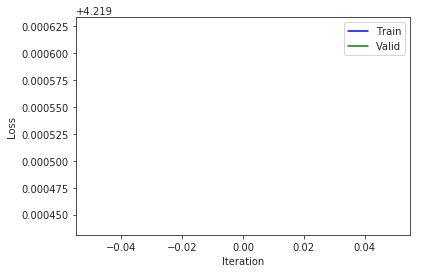

501: Training loss 1.752575. Validation loss 1.907186.
Gradient norm: 0.181016

    n; he of hoful'd even for yours,
    Wheres a hought-sons.
    But we his Hame conmer!
    
    MENECIUS:
    In me your preps everds scess in thee is beop, bet
    At Could me man sist: are peer.
    
    Clown:
    Cetiren, I werender my confeech to-Where,
    Had hiver hall har you are, nut aloove' ten nevence,
    But ay, 's cremay oth mver yething.
    Meton, to is hay husg hole,
    What you doouge to pear, that dead, to good suad a man.
    
    MARCIUS:
    Doke Charge: bish that some i' my eg hill,
    What gose windly; but of Lord.
    
    BLUMEILA EDWARD AIN



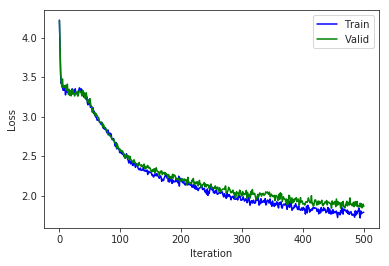

1001: Training loss 1.607255. Validation loss 1.770966.
Gradient norm: 0.200327

    isto with his noger
    And speet he like open other inframent hie
    how as not spork! Bone, I somering thou;
    Like, and brant take? and yet sey pitch we his shall
    chair bantay shast in my paips promin.
    
    OXUSY BOLINGBROK:
    And mothen, thou known ritch, and do not to whith nige:
    I'll he we ataptemire yep it, endruace, we gogeture.
    
    DULE OF YORK:
    Do! and I wise you
    Where-done we lord no mest of Romeo anor.
    
    MSTK S:
    The ennricious faile shall heign'd time a reherfain away.
    
    Nurse:
    Were in perited: shall me



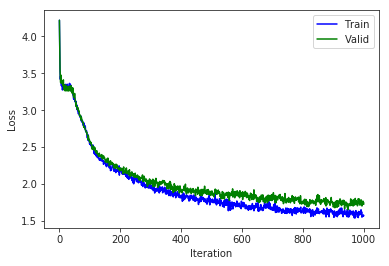

Reducing learning rate.
1501: Training loss 1.522281. Validation loss 1.668997.
Gradient norm: 0.144724

     the dields too;
    To Sengert of Godford knows day.
    Unlouran, I canstness in no say thought anoposed, and a will with peace.
    That prophilent, you sirrops,
    Than of never love to thou birst are banes
    Which bisitius
    Against thy do.
    
    ROMEO:
    Then so: your honour' bay huch thou, for well alks wounds,
    As a soul good thum, and still, and take conquept overe with egasted
    As the Sawis story I straided?
    Now that thou art Lord Gier, sair mindly chatch my father,
    To him desempy: that supper of setuck up of the



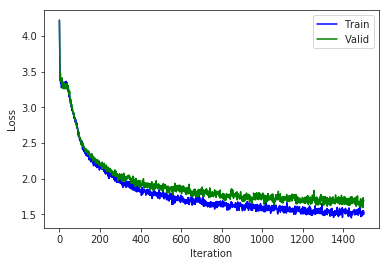

Test loss 1.868097


In [0]:
#@title Run experiment
NUM_TRAINING_ITERATIONS = 2000 #@param
REPORT_INTERVAL = 500 #@param
REDUCE_LEARNING_RATE_INTERVAL = 1500 #@param

DEPTH = 2 #@param
BATCH_SIZE = 64 #@param
NUM_HIDDEN = 128 #@param
TRUNCATION_LENGTH = 64 #@param Sequence size for training.
SAMPLE_LENGTH = 500 #@param Sequence size for sampling.
MAX_GRAD_NORM = None #@param Gradient clipping norm limit.
LEARNING_RATE = 0.01 #@param Optimizer learning rate.
REDUCE_LEARNING_RATE_MULTIPLIER = 0.1 #@param Learning rate is multiplied by this when reduced.
OPTIMIZER_EPSILON = 1e-8 #@param Adam epsilon

RNN_CORE = "rnn_cell.LSTMCell" #@param ['RNN', 'rnn_cell.LSTMCell', 'rnn_cell.GRUCell']
RNN_CORE = eval(RNN_CORE)

TESTING_ITERATIONS = 1000 #@param


print("Building the graph")
print()

tf.reset_default_graph()

graph_tensors, dataset_train = build_graph(
    depth=DEPTH, 
    batch_size=BATCH_SIZE,
    num_hidden=NUM_HIDDEN,
    truncation_length=TRUNCATION_LENGTH,
    sample_length=SAMPLE_LENGTH,
    max_grad_norm=MAX_GRAD_NORM,
    initial_learning_rate=LEARNING_RATE,
    reduce_learning_rate_multiplier=REDUCE_LEARNING_RATE_MULTIPLIER,
    optimizer_epsilon=OPTIMIZER_EPSILON,
    rnn_core=RNN_CORE)

init = tf.global_variables_initializer()

# Train the network.
print("Training starts...")
print()

sess = tf.train.MonitoredSession()
sess.run(init)

train_losses = []
valid_losses = []

for train_iteration in range(NUM_TRAINING_ITERATIONS):
  if train_iteration % REPORT_INTERVAL == 1:
    train_loss_v, valid_loss_v, _, raw_gradients = sess.run(
        (graph_tensors["train_loss"],
         graph_tensors["valid_loss"],
         graph_tensors["train_step"],
         graph_tensors["raw_gradients"]))

    train_generated_string_v = sess.run(
        graph_tensors["train_generated_string"])

    train_generated_string_human = dataset_train.to_human_readable(
        (train_generated_string_v, 0), False, indices=[0], pretify=True)

    print("%d: Training loss %f. Validation loss %f." % (
                    train_iteration,
                    train_loss_v,
                    valid_loss_v))

    print("Gradient norm: %f" % np.linalg.norm(np.concatenate(
        [g.reshape(-1) for g in raw_gradients])))
    print()
    print(train_generated_string_human)
    print()
    

    plt.figure()
    plt.plot(train_losses, c='b', label='Train')
    plt.plot(valid_losses, c='g', label='Valid')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()
  else:
    train_loss_v, valid_loss_v, _ = sess.run((graph_tensors["train_loss"],
                                              graph_tensors["valid_loss"],
                                              graph_tensors["train_step"]))
    
  train_losses.append(train_loss_v)
  valid_losses.append(valid_loss_v)


  if (train_iteration + 1) % REDUCE_LEARNING_RATE_INTERVAL == 0:
    sess.run(graph_tensors["reduce_learning_rate"])
    print("Reducing learning rate.")

test_losses = []    
for k in range(TESTING_ITERATIONS):    
  test_loss_v = sess.run(graph_tensors["test_loss"])
  test_losses.append(test_loss_v)
  
print("Test loss %f" % np.mean(test_losses))


## Ex 3.1   Analysis of single neurons and gates

We will now look at the individual activations of neurons in a Recurrent network. For this to work, you need to have completed the previous exercise in which you expose the network activations, as well as train a model.

For a similar analysis, see [this paper](https://arxiv.org/pdf/1506.02078.pdf).

In [0]:
#@title String plot function

def string_plot(chars, values, title=None):
  """
  Given a string "chars" and a vector of numbers "values" of the same length
  displays the string, using "|" as EOL symbol, and colors each character
  background using corresponding value in values
  """
  
  assert len(chars) == len(values)
  
  lines = []
  line = ""
  for char in chars:
    if char != '|':
      line += char
    else:
      line += " "
      lines.append(line)
      line = ""
  lines.append(line)
  
  height = len(lines) 
  width = max(map(len, lines))
    
  data = np.zeros((height, width))
  data[:,:] = np.nan
  
  pos = 0
  for lid, line in enumerate(lines):
    data[lid, :len(line)] = values[pos: pos+len(line)]
    pos = pos+len(line)
    
  assert pos == len(values)
    
  plt.figure(figsize=(width * 0.3, height * 0.3))
  plt.title(title)
  plt.imshow(data.reshape((height, width)), interpolation='none',
             cmap='Reds', alpha=0.5)
  plt.axis('off')
  
  for lid, line in enumerate(lines):
    for cid, char in enumerate(line):
      plt.text(cid-0.2,lid+0.2,char,color='k',fontsize=9)

  plt.show()
  plt.close()

In [0]:
#@title Generate some new text and corresponding activations

text, activations = sess.run([
    graph_tensors['train_generated_string'],
    graph_tensors['activations']
])


print(dataset_train.to_human_readable((text, 0), False, indices=[0],
                                      pretify=True))

    , thy wation in geege sparge, by that neven, to sin
    Bowe his wad over this his bode fort his marlaight?
    To will Fot our pardaking thy jeast
    To keeps mine is lance, and we thou on,
    Which themdes arm!
    
    GLOUCESTER:
    What if the spother of compen father thou semberly, and you nag,
    And, we are meet fo' though begue she before when?
    
    LADY CAPULET:
    O, that, and, you should day it chaze good hupply halt is their a gunder,
    But the queen thought heart is surject yoursh,
    The will our chiught, splain Henry t


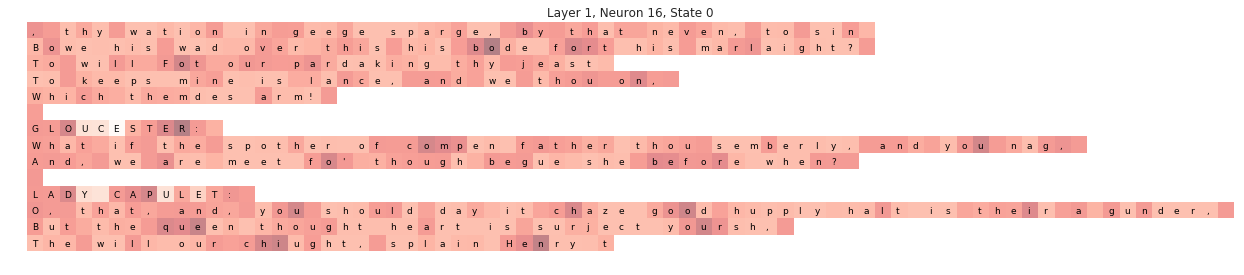

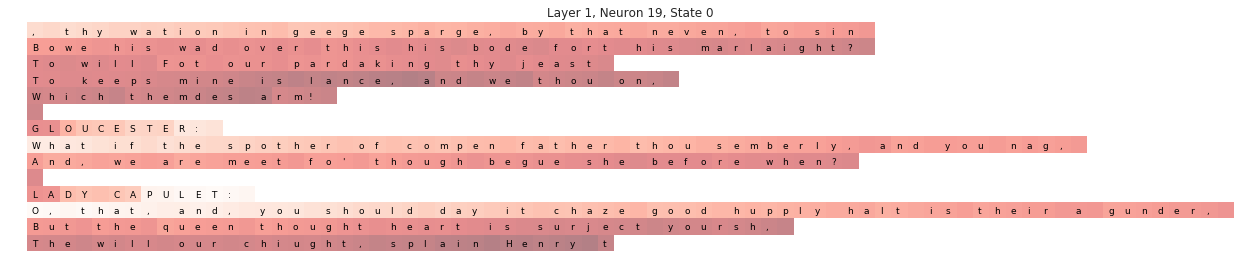

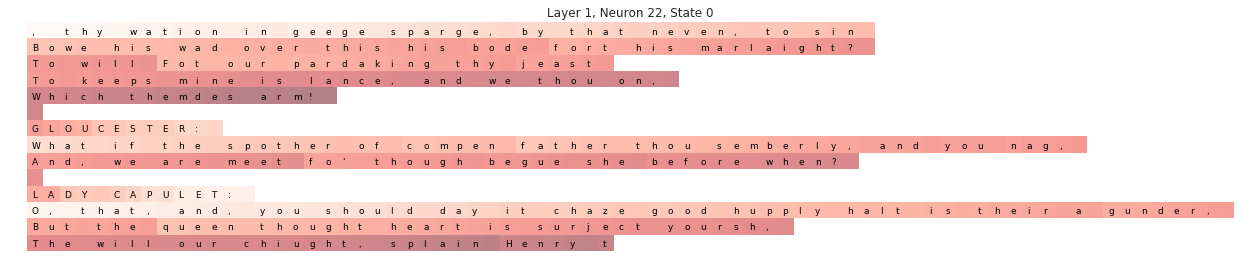

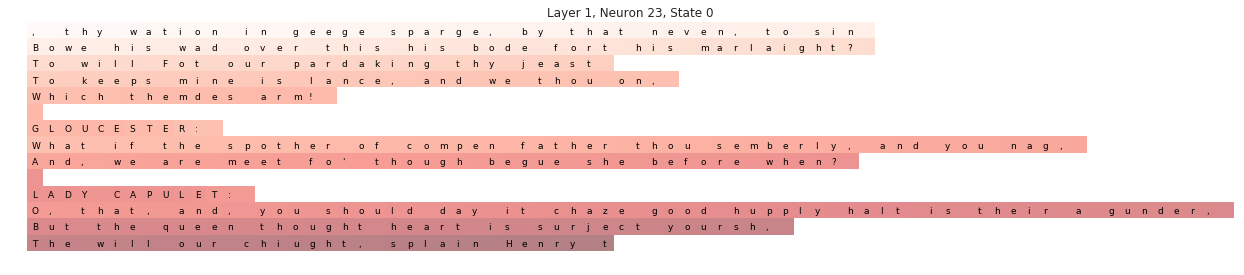

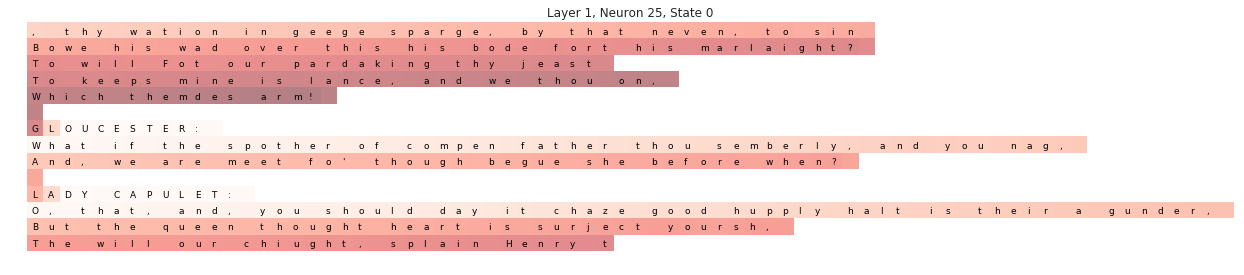

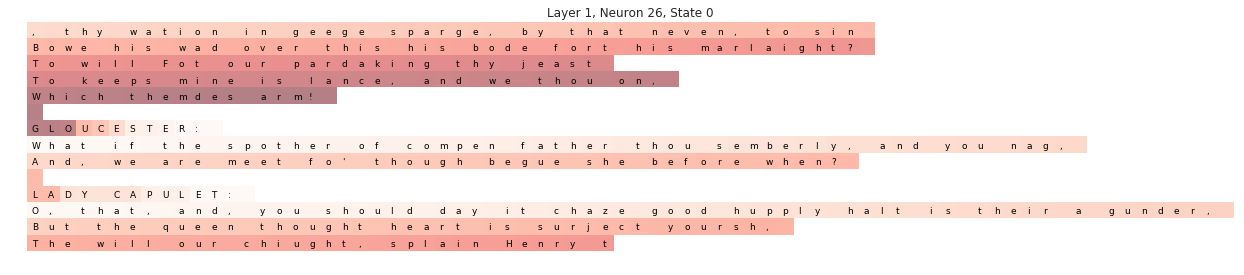

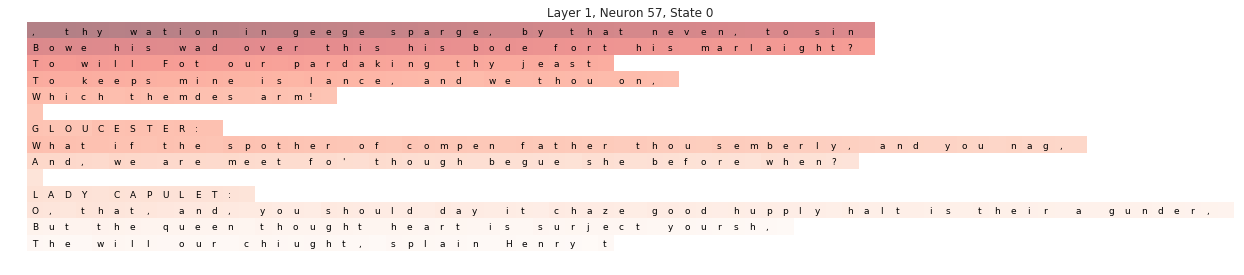

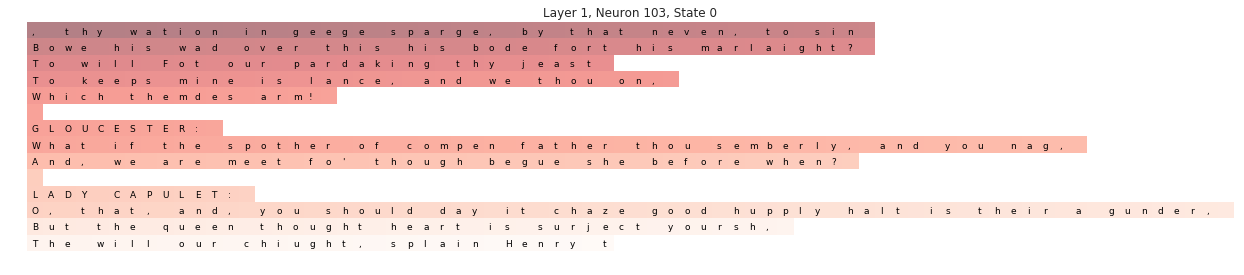

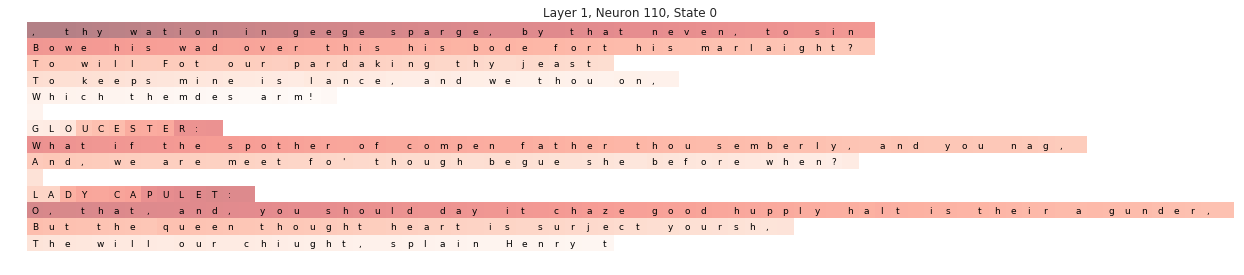

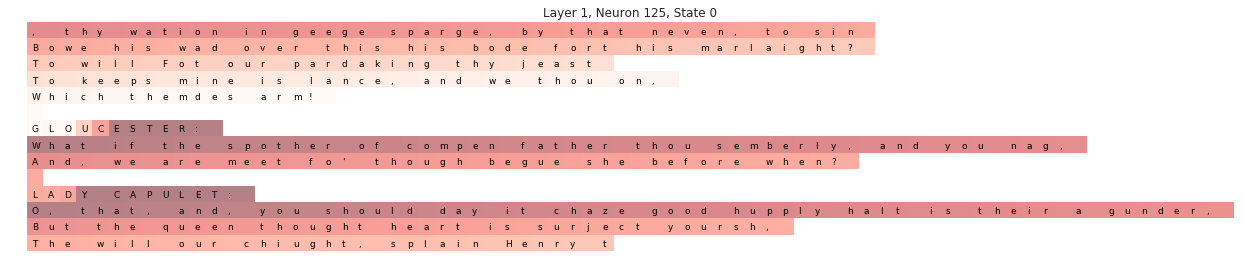

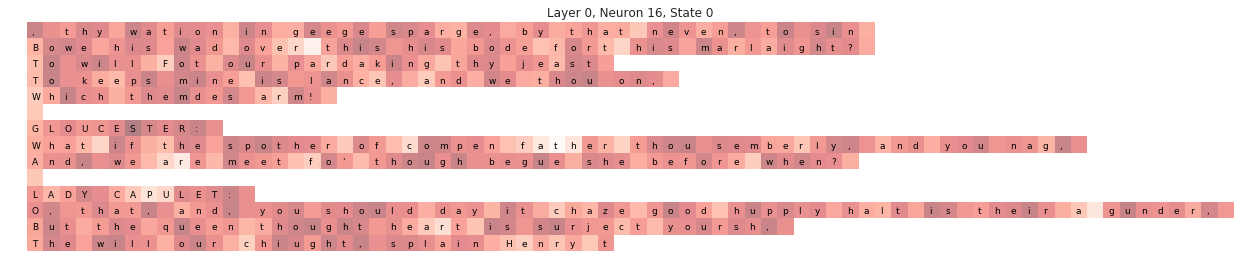

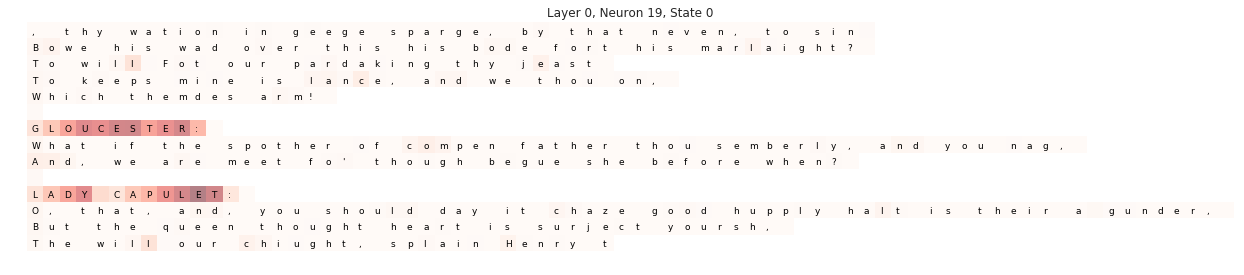

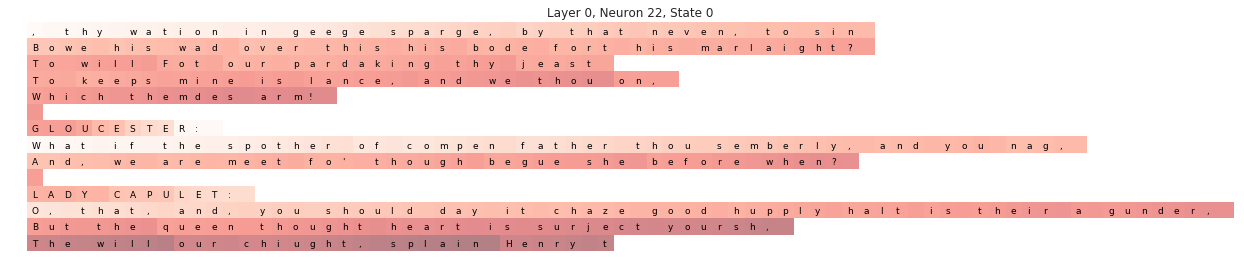

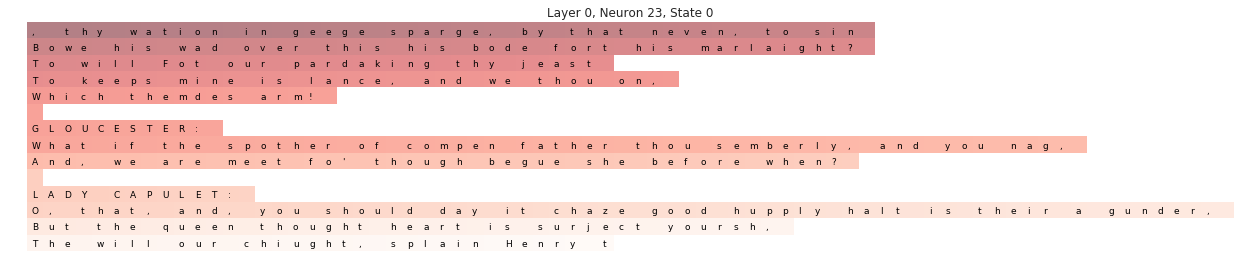

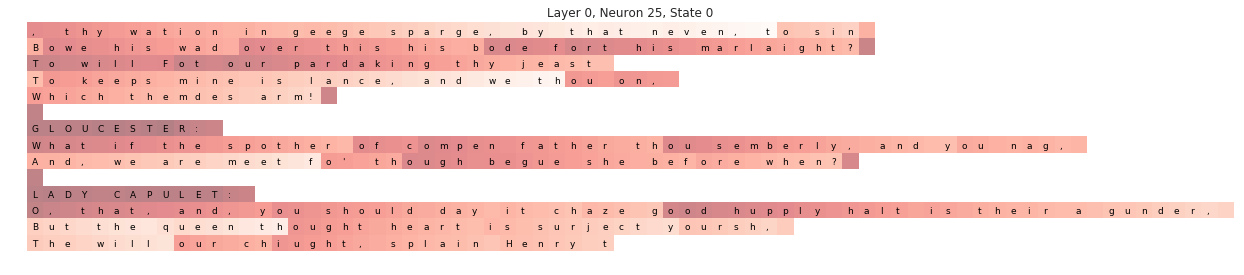

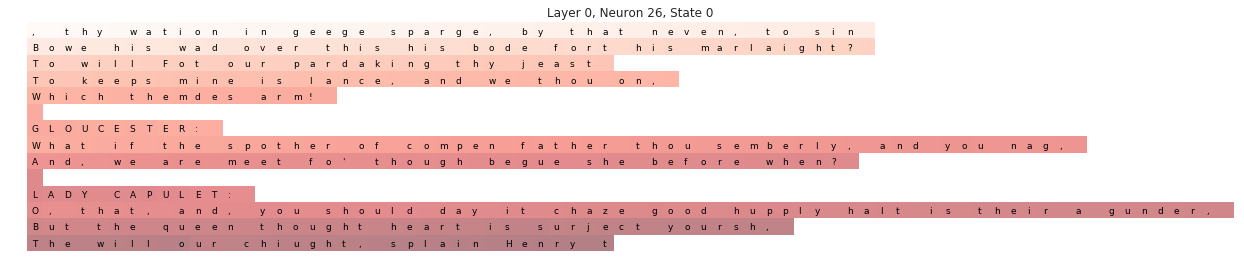

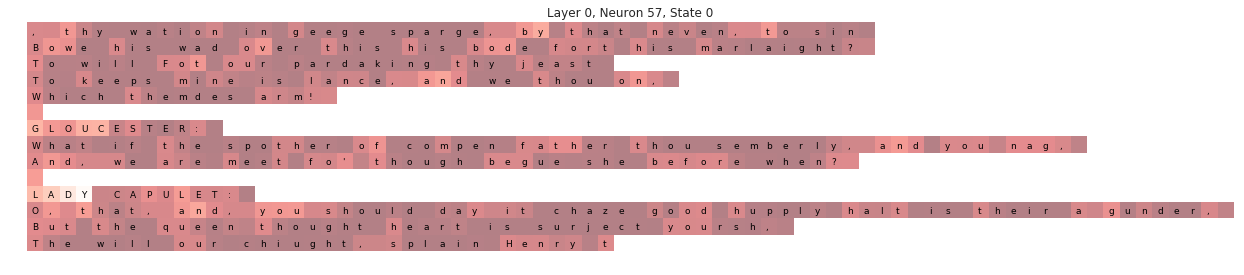

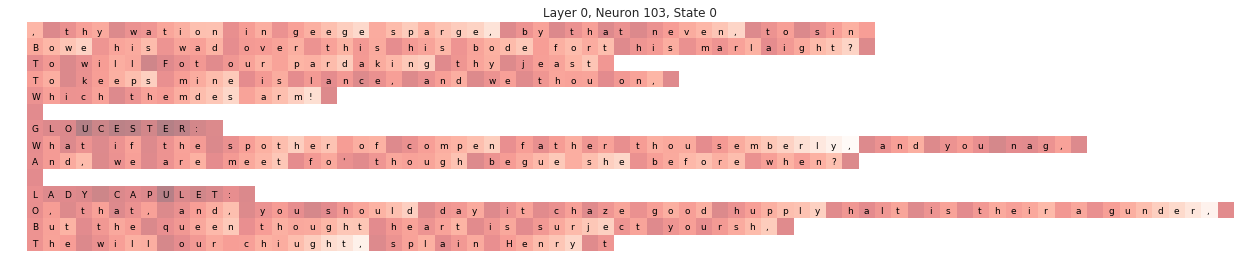

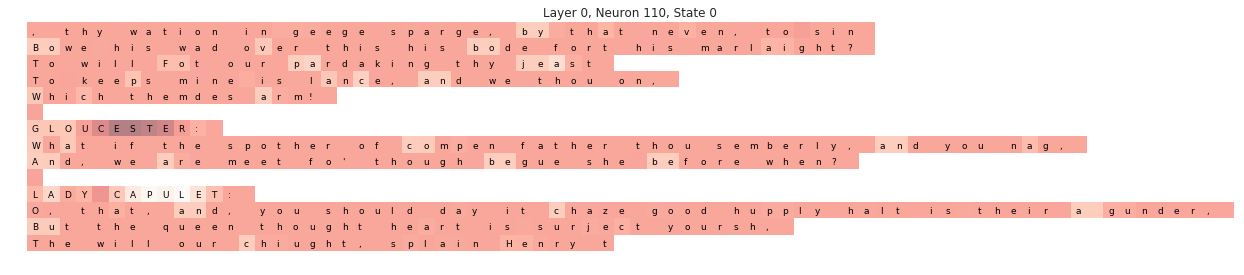

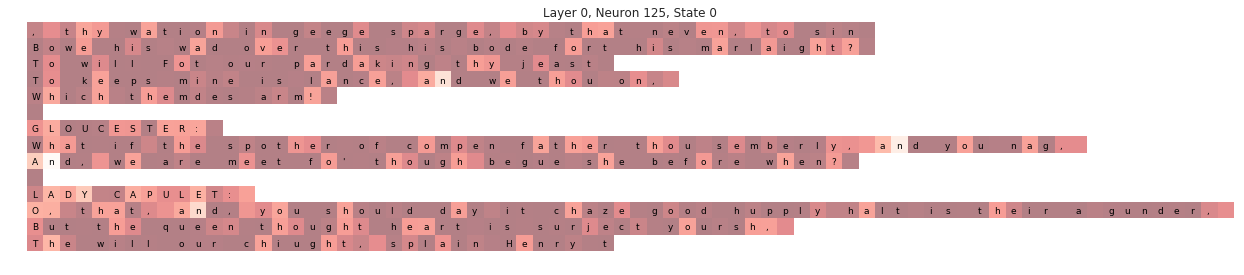

In [0]:
#@title Display activities of random neurons

NUMBER_OF_NEURONS = 10  #@param {type:"integer"}
STATE_DIM = 0  #@param {type:"integer"}

if len(activations.shape) == 5:
  selected_activations = activations[:, :, STATE_DIM, 0, :]
else:
  selected_activations = activations[:, :, 0, :]

chars = list(dataset_train.to_human_readable(
        (text, 0), False, indices=[0]))

neurons_ids = np.random.choice(range(activations.shape[-1]), 
                               min(NUMBER_OF_NEURONS, activations.shape[-1]),
                               replace=False)

for layer_id in reversed(range(selected_activations.shape[1])): 
  values = selected_activations[:, layer_id, :].T
  for neuron in sorted(neurons_ids):
    string_plot(chars, 
                values[neuron],
                title='Layer %d, Neuron %d, State %d' 
                % (layer_id, neuron, STATE_DIM))


### What kind of neurons can we expect to find?

* Lots of counting neurons (their activity is just growing/decreasing independently from input)
* Names neuron - activates around names of people in the play, such as HAMLET: or JOHN OF GAUNT:
* Line width neuron - with activity proportional to the length of the current line (number of charaters since last "|")
* Paragraph length neuron - activity proportional to the length of the paragraph in lines
* Special character neurons - such as coding for probability of generating ":"
* Many, many mixtures of the above

Note, that if neurons like these do not appear it does not mean that network does not "know" these elements. Highly discriminative, single neuron decoupling is not something neural networks are trained to do, it is just an empirical observation, shared across many domains (cat neurons in visual classifiers etc.). Knowledge can be represented in many other ways, in particular the fact that it is represented in a single neuron does not mean network does not have a distributed "backup" of the same knowledge somewhere else.


## Ex 3.2   Analysis of the state dynamics

In this exercise, we will visualize the activations in a different way, by projecting them to 2 dimensions, via dimensionality reduction. 

When using different projection techniques, you willl see different results. For example, PCA will display the directions with most variance in the data.

In [0]:
#@title Compute 2D projection of the hidden state

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

projector = 'TSNE' #@param ['PCA', 'TSNE', 'Isomap']
projector_fun = eval(projector)

kwargs = {
    'TSNE': {'perplexity': 50},
    'PCA': {},
    'Isomap': {}
}

values = selected_activations.reshape(selected_activations.shape[0], -1)
projector = projector_fun(n_components=2, **kwargs[projector])

values_2d = projector.fit_transform(values)


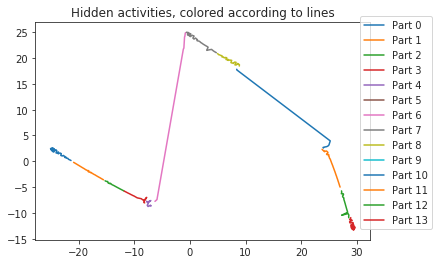

Part 0
    , thy wation in geege sparge, by that neven, to sin
    

Part 1
    Bowe his wad over this his bode fort his marlaight?
    

Part 2
    To will Fot our pardaking thy jeast
    

Part 3
    To keeps mine is lance, and we thou on,
    

Part 4
    Which themdes arm!
    

Part 5
    
    

Part 6
    GLOUCESTER:
    

Part 7
    What if the spother of compen father thou semberly, and you nag,
    

Part 8
    And, we are meet fo' though begue she before when?
    

Part 9
    
    

Part 10
    LADY CAPULET:
    

Part 11
    O, that, and, you should day it chaze good hupply halt is their a gunder,
    

Part 12
    But the queen thought heart is surject yoursh,
    

Part 13
    The will our chiught, splain Henry t



In [0]:
#@title Data plotter

splits = {
    'nothing': ('$', ),
    'lines': ('|', ),
    'paragraphs': ('|', '|', ),
}

split_criterion = 'lines' #@param ['nothing', 'lines', 'paragraphs']

parts = []
part = ""
for cid, char in enumerate(chars):
  match = True
  part += char
  for k in range(min(len(chars)-cid, len(splits[split_criterion]))):
    if chars[cid+k] != splits[split_criterion][k]:
      match = False
  if match:
    parts.append(len(part))
    part = ""
    
if len(part)>0:    
  parts.append(len(part))    
  

plt.figure()
plt.title('Hidden activities, colored according to %s' 
          % split_criterion.replace('_', ' '))
current = 0
for part_id, part in enumerate(parts):
  plt.plot(values_2d[current:current+part,0],
           values_2d[current:current+part,1],
           label='Part %d' % part_id)
  current += part
  
plt.legend(bbox_to_anchor=(1.2, 1.05))  
plt.show()

current = 0
for part_id, part in enumerate(parts):
  print('Part %d' % part_id)
  print(dataset_train.to_human_readable((text[current:current+part], 0),
                                              False, indices=[0],
                                              pretify=True))
  print()
  
  current += part
  

### So what am I looking at?

2D projections of high-dimensional spaces are always loosing a lot of information, however the general structure can still be recovered. Here, one can see that both paragraph-splits and line-splits can be decoded by just looking at the dynamics of the hidden state, giving more insights into internals of an RNN. Note, that contrary to single-neuron analysis, here we are truly looking at the whole picture, thus what is observed is likely behind the dynamics of this model.

Canonical Answer:
Recurrent nets use the dimensions of the hidden state to encode position in the sequence, like a counter. The trajectory through the hidden space can be thought of some form of memory. E.g. the RNN could be storing bits of information by setting a dimension to +1 or -1.

# Done.